# Data Import

In [1]:
# %%capture
# !pip install scikit-learn
# !pip install fancyimpute
# !pip install xgboost
# !pip install graphviz
# !pip install GPyOpt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import graphviz
from fancyimpute import IterativeImputer
import shap
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from fancyimpute import IterativeImputer
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xuv53fi3 because the default path (/gpfs/home/pandik01/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
df = pd.read_csv('/gpfs/data/proteomics/projects/pandik01/cleaned_data_09_08_2021.csv')

In [5]:
#changing cols with mixed dtypes to single dtype 
df.astype({df.columns[10]:'str', df.columns[11]:'str', df.columns[38]:'str'})

df.shape

(31580, 415)

In [6]:
col_names = ['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm', 'Abortions', 
             'Living.at.Delivery.Ct', 'RACE_White', 'RACE_African_American', 'RACE_Asian', 
             'RACE_Native_Hawaiian_or_Other_Pacific_Islander', 'RACE_Other_Race', 
             'ETHNICITY_Not_of_Spanish_Hispanic_Origin','ETHNICITY_Patient_Refused', 
             'ETHNICITY_Unknown', 'R.BMI', 'GA_IN_DAYS', 'Insulin', 'Insulin.NPH', 'Insulin.aspart', 'Insulin.detemir',
             'Insulin.glargine','Insulin.lispro','Insulin.regular', 'Oral.glycemic','GLUCOSE.CHALLENGE..PREGNANCY',
             'GLUCOSE.TOLERANCE.TEST.1.HOUR','GLUCOSE.TOLERANCE.TEST.2.HOUR','GLUCOSE.TOLERANCE.TEST.3.HOUR',
            'HEMOGLOBIN_FIRST_TRIMESTER','HEMOGLOBIN_SECOND_TRIMESTER','HEMOGLOBIN_THIRD_TRIMESTER',
             'PMH_Macrosomia_or_LGA', 'Macrosomia','IUGR','IUFD_or_demise','Grand_multip','Apgar.1','Apgar.5',
             'Apgar.10','Baby.Sex']
df = df[col_names]
        

In [7]:
#remaining features with NaN values
df.columns[df.isna().sum()!=0]

Index(['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm',
       'Abortions', 'Living.at.Delivery.Ct', 'R.BMI', 'GA_IN_DAYS',
       'GLUCOSE.CHALLENGE..PREGNANCY', 'GLUCOSE.TOLERANCE.TEST.1.HOUR',
       'GLUCOSE.TOLERANCE.TEST.2.HOUR', 'GLUCOSE.TOLERANCE.TEST.3.HOUR',
       'HEMOGLOBIN_FIRST_TRIMESTER', 'HEMOGLOBIN_SECOND_TRIMESTER',
       'HEMOGLOBIN_THIRD_TRIMESTER', 'Apgar.1', 'Apgar.5', 'Apgar.10',
       'Baby.Sex'],
      dtype='object')

In [8]:
#combining 'Patient.Age' and 'AGE_AT_DELIVERY' columns to fill NaN

#converting dtype to int for both columns
df['Patient.Age'] = df['Patient.Age'].fillna(0).astype(int)
df['AGE_AT_DELIVERY'] = df['AGE_AT_DELIVERY'].fillna(0).astype(int)

#replacing NaN values in 'Patient.Age' using 'AGE_AT_DELIVERY' values
df.iloc[:,:1] = df['AGE_AT_DELIVERY'].combine_first(df['Patient.Age'])

#dropping one of two age descriptors
df = df.drop(columns = 'Patient.Age') #redundant

#confirming no NaN values in Patient.Age
df[df['AGE_AT_DELIVERY'].isnull()]

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living.at.Delivery.Ct,RACE_White,RACE_African_American,RACE_Asian,...,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar.1,Apgar.5,Apgar.10,Baby.Sex


In [9]:
## remaining features with NaN values
# df.isna().sum()

In [10]:
#dropping all columns where most entries are NaN (>50%)
df = df.dropna(axis=1, thresh = 15000)

#remaining features with NaN values
df.shape

(31580, 34)

# Data Preprocessing

In [11]:
#imputing NaN values, outputs np array
imp = IterativeImputer()
array_imp = imp.fit_transform(df)

In [12]:
#converting np array back to df
cols = df.columns
df_imp = pd.DataFrame(np.array(array_imp), columns = cols)
df_imp.head()

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living.at.Delivery.Ct,RACE_White,RACE_African_American,RACE_Asian,...,Oral.glycemic,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar.1,Apgar.5,Baby.Sex
0,36.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,14.1,0.0,0.0,0.0,0.0,0.0,7.0,9.0,1.0
1,36.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,14.1,0.0,0.0,0.0,0.0,0.0,9.0,9.0,1.0
2,30.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,12.4,0.0,0.0,0.0,0.0,0.0,8.0,9.0,1.0
3,31.0,4.0,3.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,13.7,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0
4,40.0,4.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,12.8,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0


In [13]:
#replacing spaces in df with underscores
df_imp.replace(' ', '_', regex=True, inplace=True)

#replacing spaces and periods in column names with underscores (necessary for plotting tree later on)
df_imp.columns = df_imp.columns.str.replace(' ', '_')
df_imp.columns = df_imp.columns.str.replace('.', '_')

df_imp.head()

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living_at_Delivery_Ct,RACE_White,RACE_African_American,RACE_Asian,...,Oral_glycemic,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar_1,Apgar_5,Baby_Sex
0,36.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,14.1,0.0,0.0,0.0,0.0,0.0,7.0,9.0,1.0
1,36.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,14.1,0.0,0.0,0.0,0.0,0.0,9.0,9.0,1.0
2,30.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,12.4,0.0,0.0,0.0,0.0,0.0,8.0,9.0,1.0
3,31.0,4.0,3.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,13.7,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0
4,40.0,4.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,12.8,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0


# Splitting Data

In [14]:
#creating featuers variable by removing Macrosomia column
X = df_imp.drop('Macrosomia', axis = 1).copy()

#creating labels variable using Macrosomia column
y = pd.DataFrame(df_imp['Macrosomia'])

In [15]:
#splitting data into train/validation/test (60/20/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle = True, stratify = y_train)

In [16]:
X_train.shape

(18948, 33)

In [17]:
X_valid.shape

(6316, 33)

In [18]:
X_test.shape

(6316, 33)

In [19]:
#verifying class balance is maintained across datasets as bar graph

def plot_counts(df, title):
    Normal, Macrosomia = df['Macrosomia'].value_counts()
    plt.figure(figsize=(4,4))
    sns.countplot('Macrosomia', data=df, palette="Paired")
    plt.title(title)
    plt.annotate(Normal, xy=(-0.2, 250), xytext=(-0.1, 280), size=12, color='black')
    plt.annotate(Macrosomia, xy=(-0.2, 250), xytext=(0.9, 280), size=12, color='black')
    plt.show()

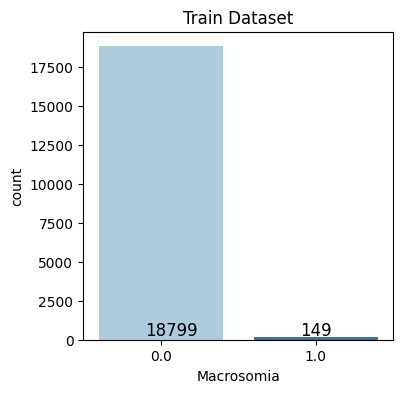

In [20]:
plot_counts(y_train, 'Train Dataset')

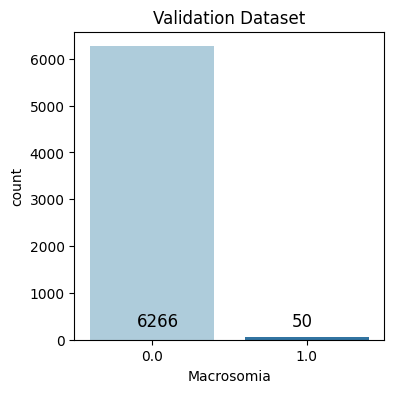

In [21]:
plot_counts(y_valid, 'Validation Dataset')

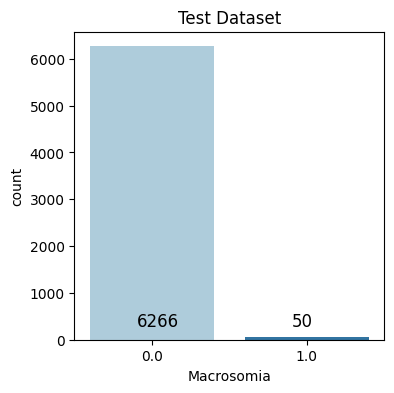

In [22]:
plot_counts(y_test, 'Test Dataset')

# Model Building

## Experiment 5:

### Imputation method: fancyimpute (FI)
### Class imbalance: Yes (CI)
### Feature selection: No (No FS)
### Optimization: Grid search (GS)

In [23]:
#fitting model to train set
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=126, seed=42)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric=['aucpr', 'error'],
           eval_set=[(X_train, y_train), (X_valid, y_valid)])

[0]	validation_0-aucpr:0.06855	validation_0-error:0.31344	validation_1-aucpr:0.03186	validation_1-error:0.32315
[1]	validation_0-aucpr:0.08725	validation_0-error:0.24356	validation_1-aucpr:0.02316	validation_1-error:0.25174
[2]	validation_0-aucpr:0.10188	validation_0-error:0.20799	validation_1-aucpr:0.03179	validation_1-error:0.21406
[3]	validation_0-aucpr:0.13477	validation_0-error:0.19791	validation_1-aucpr:0.03832	validation_1-error:0.20567
[4]	validation_0-aucpr:0.12870	validation_0-error:0.17680	validation_1-aucpr:0.02685	validation_1-error:0.18461
[5]	validation_0-aucpr:0.14033	validation_0-error:0.16883	validation_1-aucpr:0.01972	validation_1-error:0.17733
[6]	validation_0-aucpr:0.16611	validation_0-error:0.14904	validation_1-aucpr:0.02070	validation_1-error:0.16466
[7]	validation_0-aucpr:0.17361	validation_0-error:0.14397	validation_1-aucpr:0.02181	validation_1-error:0.15864
[8]	validation_0-aucpr:0.18387	validation_0-error:0.13437	validation_1-aucpr:0.01885	validation_1-error:

[73]	validation_0-aucpr:0.98129	validation_0-error:0.01742	validation_1-aucpr:0.04377	validation_1-error:0.02850
[74]	validation_0-aucpr:0.98073	validation_0-error:0.01720	validation_1-aucpr:0.04255	validation_1-error:0.02834
[75]	validation_0-aucpr:0.98042	validation_0-error:0.01710	validation_1-aucpr:0.04335	validation_1-error:0.02802
[76]	validation_0-aucpr:0.98698	validation_0-error:0.01620	validation_1-aucpr:0.04204	validation_1-error:0.02739
[77]	validation_0-aucpr:0.98859	validation_0-error:0.01541	validation_1-aucpr:0.04205	validation_1-error:0.02644
[78]	validation_0-aucpr:0.98939	validation_0-error:0.01520	validation_1-aucpr:0.04194	validation_1-error:0.02644
[79]	validation_0-aucpr:0.98945	validation_0-error:0.01515	validation_1-aucpr:0.04194	validation_1-error:0.02612
[80]	validation_0-aucpr:0.99051	validation_0-error:0.01393	validation_1-aucpr:0.04226	validation_1-error:0.02470
[81]	validation_0-aucpr:0.99188	validation_0-error:0.01341	validation_1-aucpr:0.04211	validation

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

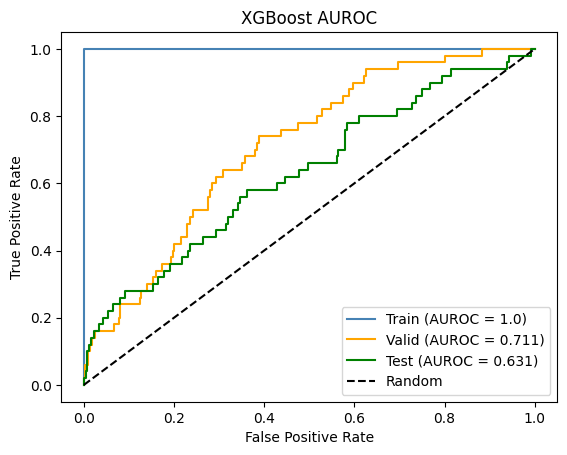

In [24]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

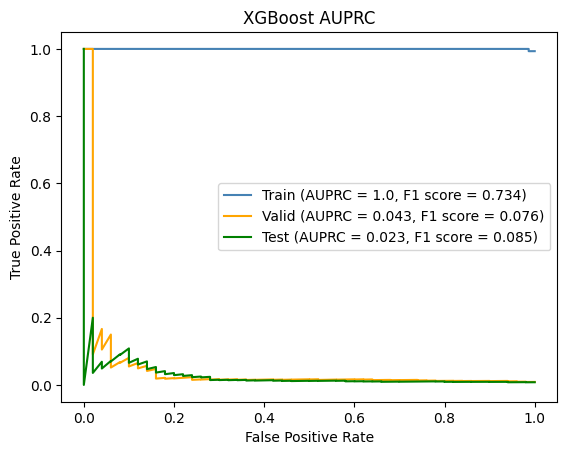

In [25]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

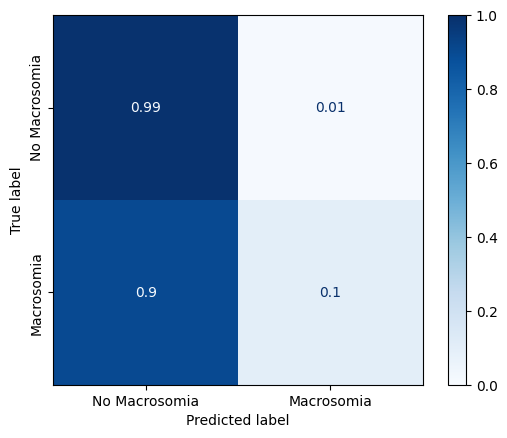

In [26]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [27]:
# #optimizing using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [28]:
# #ROUND 2

# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'gamma': [0],
#     'reg_lambda': [5],
#     'n_estimators': [30, 40, 50],
#     'min_child_weight': [3, 4, 5]
# }

In [32]:
#ROUND 3

param_grid = {
    'max_depth': [4],
    'learning_rate': [0.1],
    'gamma': [0],
    'reg_lambda': [5],
    'n_estimators': [40],
    'min_child_weight': [1, 2, 3]
}

In [33]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                               scale_pos_weight = 126),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [34]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',  
                  eval_set=[(X_valid, y_valid)],
                  verbose=True)
print(optimal_params.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[0]	validation_0-auc:0.67140
[1]	validation_0-auc:0.73179
[2]	validation_0-auc:0.70855
[3]	validation_0-auc:0.73555
[4]	validation_0-auc:0.74961
[5]	validation_0-auc:0.75177
[6]	validation_0-auc:0.75084
[7]	validation_0-auc:0.77072
[8]	validation_0-auc:0.77162
[9]	validation_0-auc:0.77753
[10]	validation_0-auc:0.77449
[11]	validation_0-auc:0.77234
[12]	validation_0-auc:0.77263
[13]	validation_0-auc:0.77504
[14]	validation_0-auc:0.77338
[15]	validation_0-auc:0.77163
[16]	validation_0-auc:0.76804
[17]	validation_0-auc:0.76301
[18]	validation_0-auc:0.75588
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 40, 'reg_lambda': 5}


In [35]:
#fitting model to tuned hyperparameters
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=4,
                            min_child_weight = 3,
                            n_estimators = 40,
                            reg_lambda=5,
                            scale_pos_weight=126, #sum(negative instances) / sum(positive instances)
                            subsample=0.9,
                            colsample_bytree=0.5)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])

[0]	validation_0-auc:0.75313	validation_1-auc:0.67140	validation_2-auc:0.63621
[1]	validation_0-auc:0.81563	validation_1-auc:0.73179	validation_2-auc:0.68456
[2]	validation_0-auc:0.84752	validation_1-auc:0.70855	validation_2-auc:0.70785
[3]	validation_0-auc:0.86255	validation_1-auc:0.73555	validation_2-auc:0.72963
[4]	validation_0-auc:0.86542	validation_1-auc:0.74961	validation_2-auc:0.72664
[5]	validation_0-auc:0.87531	validation_1-auc:0.75177	validation_2-auc:0.71778
[6]	validation_0-auc:0.87719	validation_1-auc:0.75084	validation_2-auc:0.72312
[7]	validation_0-auc:0.88188	validation_1-auc:0.77072	validation_2-auc:0.72325
[8]	validation_0-auc:0.88146	validation_1-auc:0.77162	validation_2-auc:0.72359
[9]	validation_0-auc:0.88661	validation_1-auc:0.77753	validation_2-auc:0.72229
[10]	validation_0-auc:0.89144	validation_1-auc:0.77449	validation_2-auc:0.72558
[11]	validation_0-auc:0.89230	validation_1-auc:0.77234	validation_2-auc:0.72252
[12]	validation_0-auc:0.89618	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=40, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=5, ...)

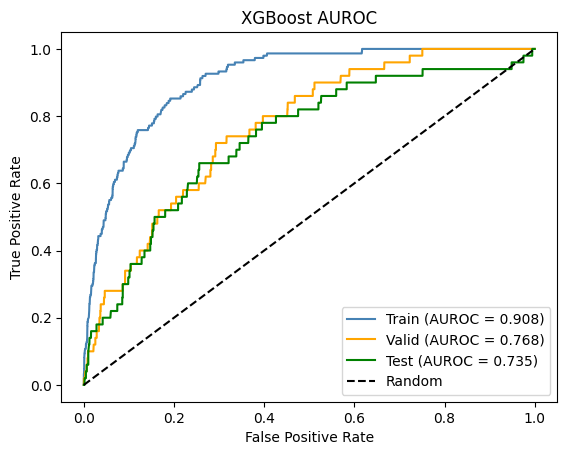

In [36]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

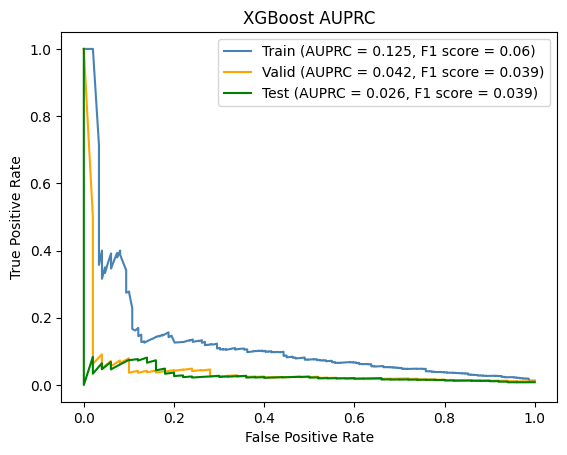

In [37]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

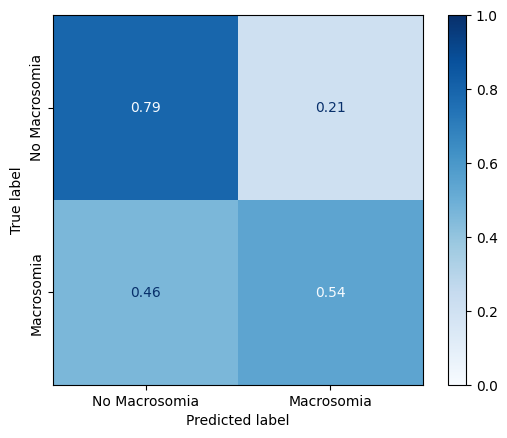

In [38]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 51.0, 'Gravida': 7.0, 'Para': 14.0, 'Term': 11.0, 'Preterm': 3.0, 'Abortions': 6.0, 'Living_at_Delivery_Ct': 6.0, 'RACE_White': 12.0, 'RACE_African_American': 1.0, 'RACE_Asian': 3.0, 'RACE_Other_Race': 1.0, 'ETHNICITY_Patient_Refused': 1.0, 'R_BMI': 81.0, 'GA_IN_DAYS': 27.0, 'Insulin': 2.0, 'Insulin_lispro': 2.0, 'HEMOGLOBIN_THIRD_TRIMESTER': 34.0, 'PMH_Macrosomia_or_LGA': 5.0, 'IUGR': 5.0, 'Apgar_1': 18.0, 'Apgar_5': 5.0, 'Baby_Sex': 4.0}
gain:  {'AGE_AT_DELIVERY': 292.45367431640625, 'Gravida': 314.0662536621094, 'Para': 456.2981262207031, 'Term': 463.74395751953125, 'Preterm': 189.16912841796875, 'Abortions': 176.1207733154297, 'Living_at_Delivery_Ct': 600.1925048828125, 'RACE_White': 250.04766845703125, 'RACE_African_American': 285.8212890625, 'RACE_Asian': 148.05860900878906, 'RACE_Other_Race': 75.61416625976562, 'ETHNICITY_Patient_Refused': 195.07345581054688, 'R_BMI': 370.75567626953125, 'GA_IN_DAYS': 384.7640380859375, 'Insulin': 377.32696533203125,

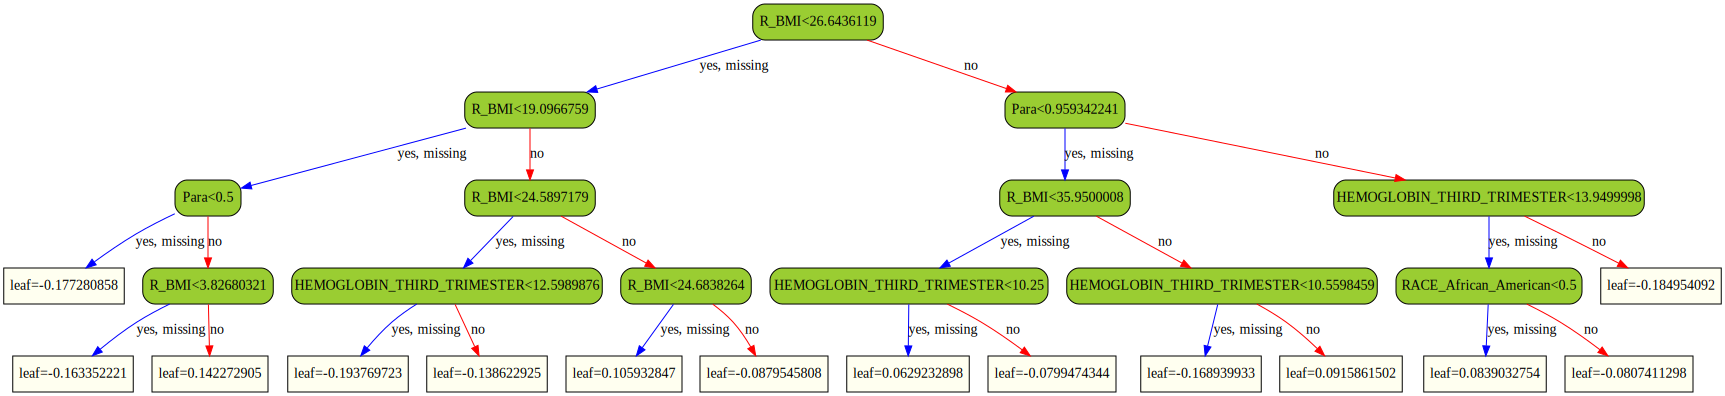

In [39]:
#plotting tree
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(clf_xgb, num_trees=1
                , size='10,10',
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

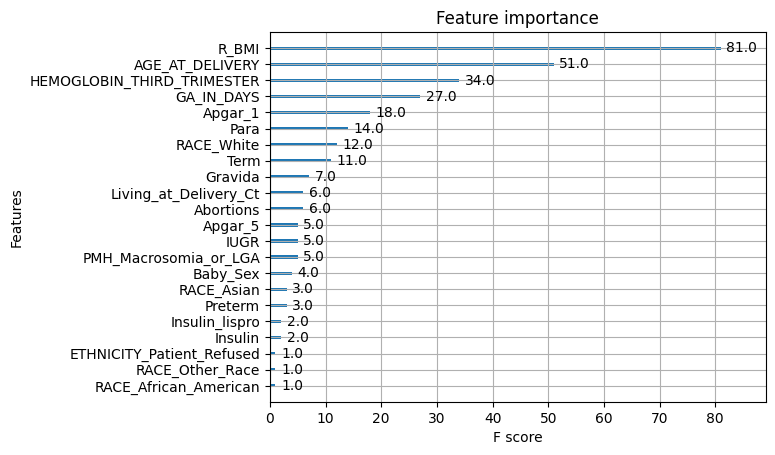

In [40]:
#plotting overall feature importance
plot_importance(clf_xgb)
plt.show()

In [41]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Experiment 6:

### Imputation method: fancyimpute (FI)
### Class imbalance: Yes (CI)
### Feature selection: No (No FS)
### Optimization: Bayesian (Bay.)

In [42]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[06:37:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:37:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:37:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.08746  |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[06:38:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:38:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:38:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

[06:39:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:39:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


|  10       | -0.08712  |  0.621    |  0.7127   |  8.185    |  2.408    |  240.1    |  18.04    |
[06:39:26] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

{'gamma': 0.6210253030076818, 'learning_rate': 0.7127163200122792, 'max_depth': 8.184814766639303, 'min_child_weight': 2.4077385795083055, 'n_estimators': 240.14563085673808, 'reg_lambda': 18.04311435327639}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6315
           1       0.00      0.00      0.00         1

    accuracy                           0.99      6316
   macro avg       0.50      0.50      0.50      6316
weighted avg       1.00      0.99      1.00      6316



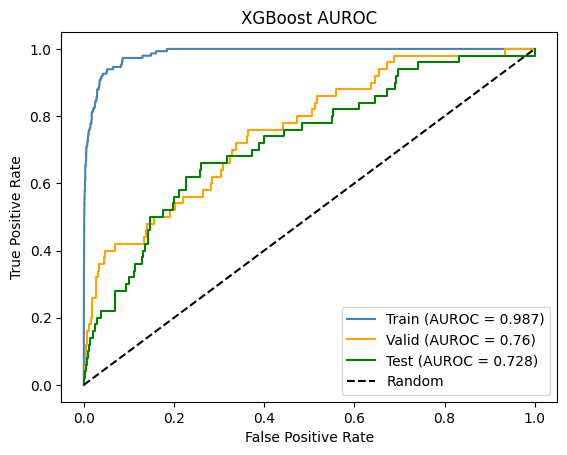

In [44]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

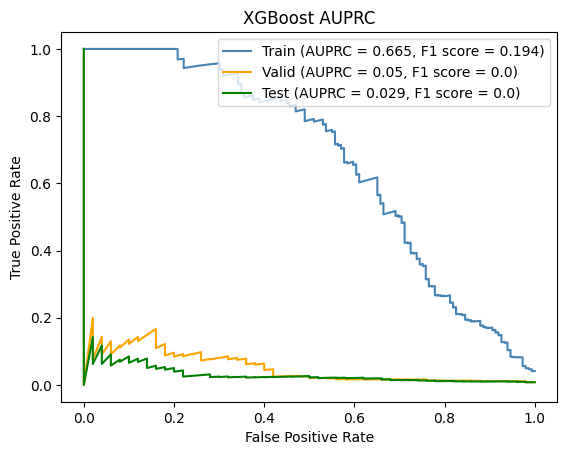

In [45]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

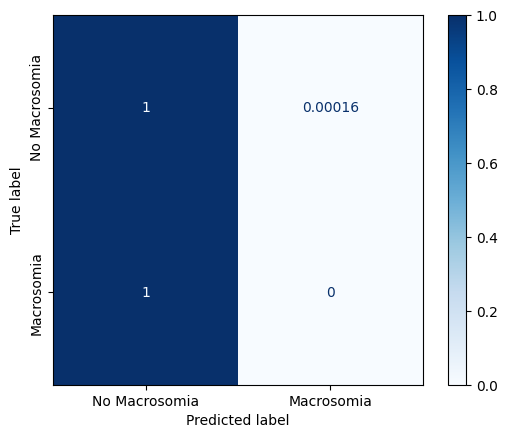

In [46]:
#plotting confusion matrix
predictions = bay_classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 75.0, 'Gravida': 26.0, 'Para': 24.0, 'Term': 10.0, 'Preterm': 3.0, 'Abortions': 20.0, 'Living_at_Delivery_Ct': 15.0, 'RACE_White': 10.0, 'RACE_African_American': 3.0, 'RACE_Asian': 4.0, 'RACE_Other_Race': 4.0, 'ETHNICITY_Not_of_Spanish_Hispanic_Origin': 4.0, 'R_BMI': 149.0, 'GA_IN_DAYS': 118.0, 'Insulin': 7.0, 'HEMOGLOBIN_THIRD_TRIMESTER': 120.0, 'PMH_Macrosomia_or_LGA': 4.0, 'IUGR': 2.0, 'Apgar_1': 28.0, 'Apgar_5': 11.0, 'Baby_Sex': 11.0}
gain:  {'AGE_AT_DELIVERY': 1.159441351890564, 'Gravida': 1.1370322704315186, 'Para': 1.2324485778808594, 'Term': 2.099971055984497, 'Preterm': 0.9527943134307861, 'Abortions': 0.8184425234794617, 'Living_at_Delivery_Ct': 1.4329679012298584, 'RACE_White': 1.7114579677581787, 'RACE_African_American': 0.8628681302070618, 'RACE_Asian': 0.7824401259422302, 'RACE_Other_Race': 0.7763020396232605, 'ETHNICITY_Not_of_Spanish_Hispanic_Origin': 0.8319252729415894, 'R_BMI': 1.1061183214187622, 'GA_IN_DAYS': 1.0660035610198975, 'Insuli

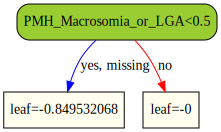

In [47]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

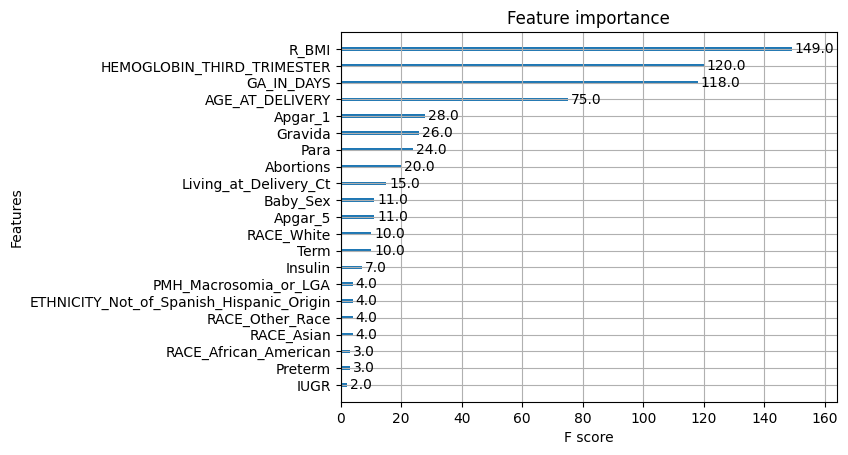

In [48]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [49]:
#plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Experiment 7:

### Imputation method: fancyimpute (FI)
### Class imbalance: Yes (CI)
### Feature selection: Yes (FS)
### Optimization: Grid search (GS)

In [50]:
#selecting features

thresholds = sort(clf_xgb.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf_xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(scale_pos_weight=126) #sum(negative instances) / sum(positive instances)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.000, n=33, Accuracy: 98.29%
Thresh=0.012, n=22, Accuracy: 98.35%
Thresh=0.023, n=21, Accuracy: 98.40%
Thresh=0.028, n=20, Accuracy: 98.26%
Thresh=0.028, n=19, Accuracy: 98.08%
Thresh=0.029, n=18, Accuracy: 98.21%
Thresh=0.030, n=17, Accuracy: 98.32%
Thresh=0.031, n=16, Accuracy: 98.02%
Thresh=0.033, n=15, Accuracy: 98.42%
Thresh=0.038, n=14, Accuracy: 98.32%
Thresh=0.039, n=13, Accuracy: 97.78%
Thresh=0.040, n=12, Accuracy: 97.37%
Thresh=0.041, n=11, Accuracy: 97.51%
Thresh=0.045, n=10, Accuracy: 97.64%
Thresh=0.046, n=9, Accuracy: 97.12%
Thresh=0.050, n=8, Accuracy: 96.44%
Thresh=0.058, n=7, Accuracy: 96.18%
Thre

In [51]:
#selecting and fitting model to threshold producing best accuracy

selection = SelectFromModel(clf_xgb, threshold=0.055, prefit=True)
select_X_train = selection.transform(X_train)

# train model
selection_model = XGBClassifier(scale_pos_weight = 126)
selection_model.fit(select_X_train, y_train)

# eval model
select_X_valid = selection.transform(X_valid)
select_X_test = selection.transform(X_test)

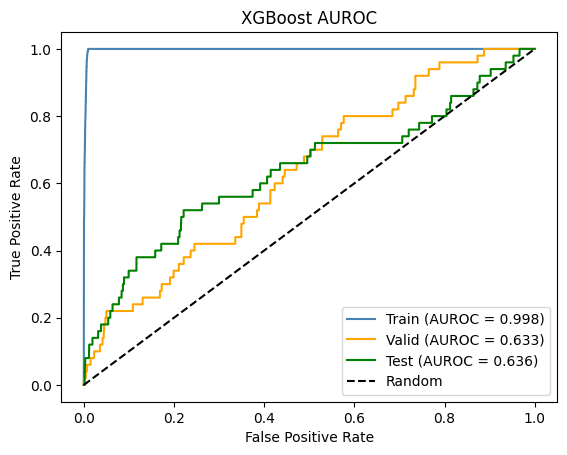

In [52]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

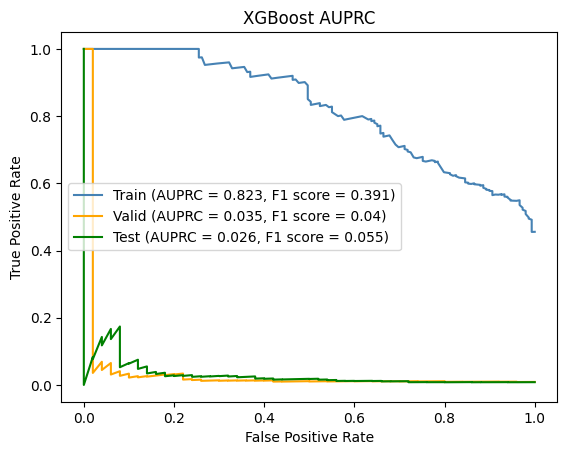

In [53]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

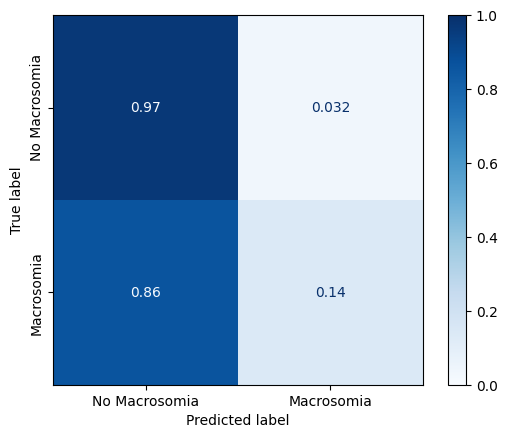

In [54]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [55]:
# #optimizing using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [58]:
# #ROUND 2

# param_grid = {
#     'max_depth': [1, 2, 3],
#     'learning_rate': [0.05],
#     'gamma': [0],
#     'reg_lambda': [5], 
#     'n_estimators': [30, 40, 50],
#     'min_child_weight': [3, 4, 5]
# }

In [62]:
# #ROUND 3

# param_grid = {
#     'max_depth': [3],
#     'learning_rate': [0.05],
#     'gamma': [0],
#     'reg_lambda': [5], 
#     'n_estimators': [10, 20, 30],
#     'min_child_weight': [1, 2, 3]
# }

In [65]:
#ROUND 4

param_grid = {
    'max_depth': [3],
    'learning_rate': [0.05],
    'gamma': [0],
    'reg_lambda': [5], 
    'n_estimators': [20],
    'min_child_weight': [0, 0.5, 1]
}

In [66]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                               scale_pos_weight = 126),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [67]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(select_X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(select_X_valid, y_valid)],
                  verbose=False)
print(optimal_params.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 20, 'reg_lambda': 5}


In [68]:
#fitting model to tuned hyperparameters
selection_model = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=0,
                            learning_rate=0.05,
                            max_depth=3,
                            min_child_weight = 0,
                            n_estimators = 20,
                            reg_lambda=5,
                            scale_pos_weight=126, #sum(negative instances) / sum(positive instances)
                            subsample=0.9,
                            colsample_bytree=0.5)

selection_model.fit(select_X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(select_X_train, y_train), (select_X_valid, y_valid), (select_X_test, y_test)])

[0]	validation_0-auc:0.74712	validation_1-auc:0.73993	validation_2-auc:0.64395
[1]	validation_0-auc:0.76793	validation_1-auc:0.76098	validation_2-auc:0.68937
[2]	validation_0-auc:0.78057	validation_1-auc:0.77409	validation_2-auc:0.68030
[3]	validation_0-auc:0.78131	validation_1-auc:0.76977	validation_2-auc:0.68903
[4]	validation_0-auc:0.77779	validation_1-auc:0.76872	validation_2-auc:0.68632
[5]	validation_0-auc:0.78957	validation_1-auc:0.75862	validation_2-auc:0.69120
[6]	validation_0-auc:0.79489	validation_1-auc:0.75458	validation_2-auc:0.69523
[7]	validation_0-auc:0.79849	validation_1-auc:0.76327	validation_2-auc:0.69699
[8]	validation_0-auc:0.79879	validation_1-auc:0.75993	validation_2-auc:0.70053
[9]	validation_0-auc:0.79897	validation_1-auc:0.75613	validation_2-auc:0.70338
[10]	validation_0-auc:0.80243	validation_1-auc:0.75952	validation_2-auc:0.69847
[11]	validation_0-auc:0.80073	validation_1-auc:0.75867	validation_2-auc:0.69925
[12]	validation_0-auc:0.80112	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=0,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=5, ...)

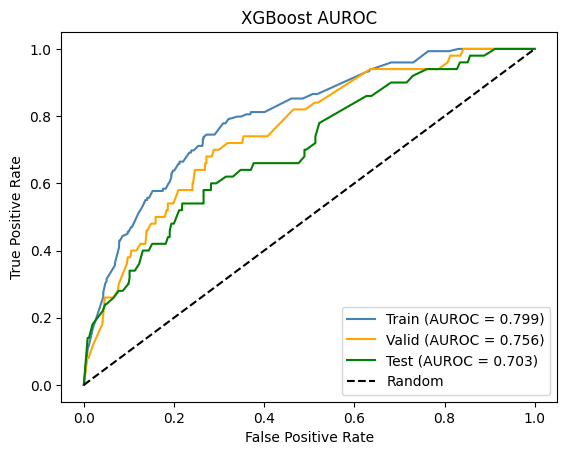

In [69]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

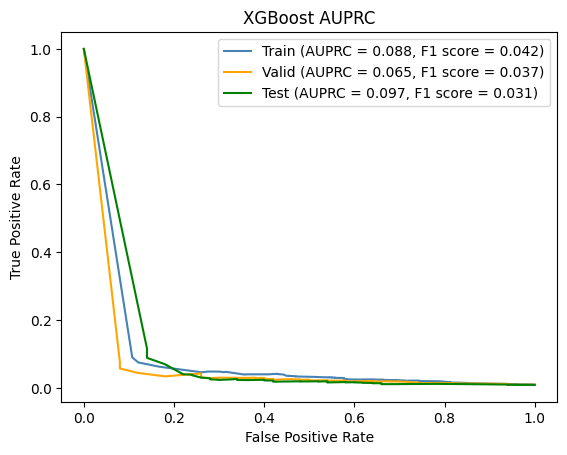

In [70]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

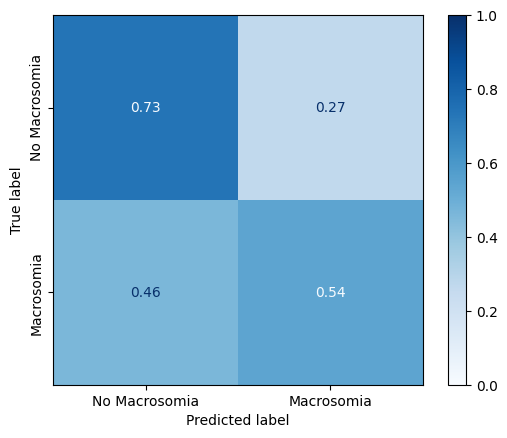

In [71]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

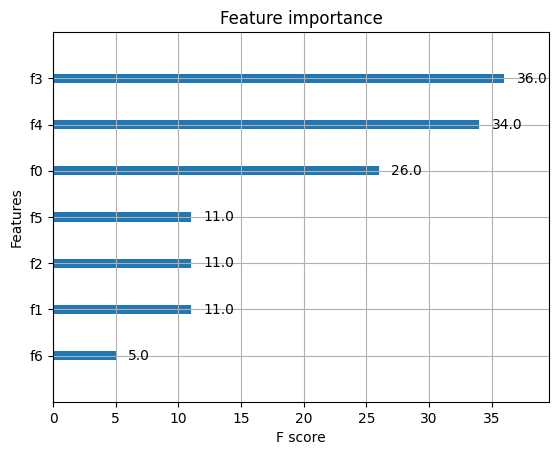

In [72]:
#plotting overall feature importance
plot_importance(selection_model)
plt.show()

In [73]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.force(shap_values[1])

## Experiment 8:

### Imputation method: fancyimpute (FI)
### Class imbalance: Yes (CI)
### Feature selection: Yes (FS)
### Optimization: Bayesian (Bay.)

In [74]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(select_X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[07:08:03] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:08:03] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:08:03] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.08746  |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[07:08:38] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:08:38] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:08:38] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

|  10       | -0.087    |  0.621    |  0.7127   |  8.185    |  2.408    |  240.1    |  18.04    |
[07:09:12] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:09:12] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:09:12] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [75]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(select_X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(select_X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

{'gamma': 0.6210253030076818, 'learning_rate': 0.7127163200122792, 'max_depth': 8.184814766639303, 'min_child_weight': 2.4077385795083055, 'n_estimators': 240.14563085673808, 'reg_lambda': 18.04311435327639}
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      6316
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99      6316
   macro avg       0.50      0.50      0.50      6316
weighted avg       1.00      0.99      1.00      6316



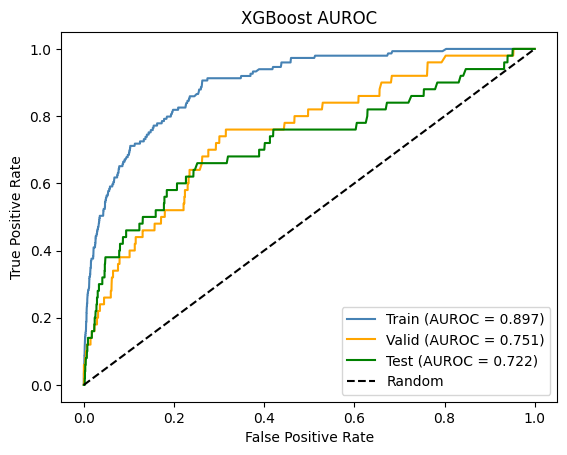

In [76]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

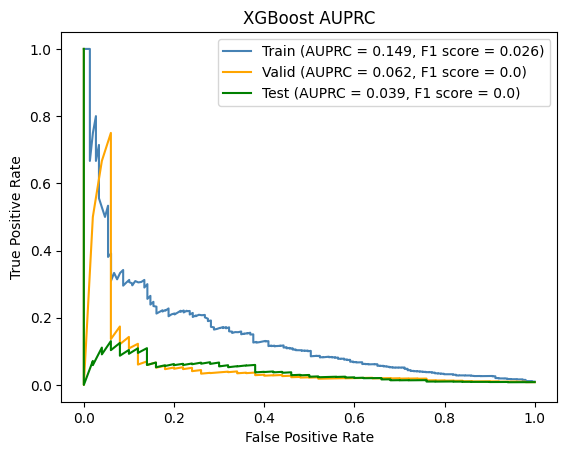

In [77]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

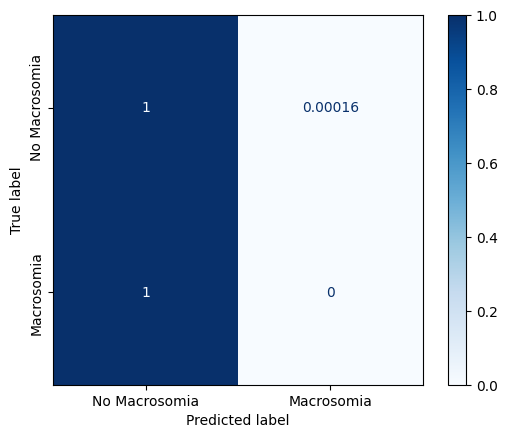

In [78]:
#plotting confusion matrix
predictions = bay_classifier.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'f0': 21.0, 'f1': 9.0, 'f2': 10.0, 'f3': 116.0, 'f4': 72.0, 'f5': 3.0, 'f6': 4.0}
gain:  {'f0': 1.1123082637786865, 'f1': 2.0312142372131348, 'f2': 1.0637462139129639, 'f3': 1.1429113149642944, 'f4': 1.054471492767334, 'f5': 1.1995315551757812, 'f6': 4.397735595703125}
cover:  {'f0': 68.89598083496094, 'f1': 76.7252197265625, 'f2': 96.69725036621094, 'f3': 62.176658630371094, 'f4': 68.60066223144531, 'f5': 899.4194946289062, 'f6': 2568.248046875}
total_gain:  {'f0': 23.358474731445312, 'f1': 18.280927658081055, 'f2': 10.63746166229248, 'f3': 132.5777130126953, 'f4': 75.92194366455078, 'f5': 3.5985946655273438, 'f6': 17.5909423828125}
total_cover:  {'f0': 1446.8155517578125, 'f1': 690.5269775390625, 'f2': 966.9725341796875, 'f3': 7212.4921875, 'f4': 4939.24755859375, 'f5': 2698.258544921875, 'f6': 10272.9921875}


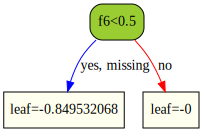

In [79]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

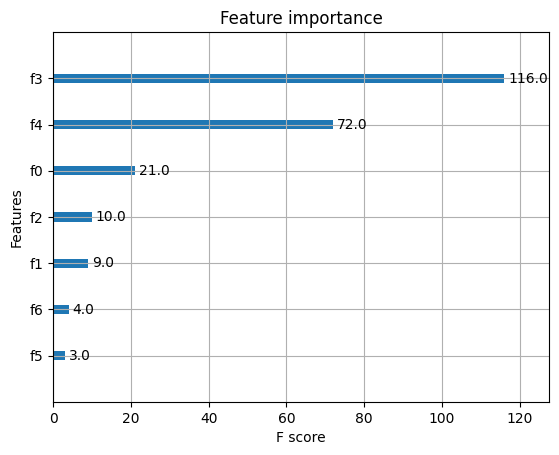

In [80]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [81]:
#plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(select_X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])